# **Anomaly Detection: Esempio di Applicazione Industriale (pt. 2)**

Nel notebook precedente intitolato *Anomaly Detection: Esempio di Applicazione Industriale (pt. 1)*, è stato analizzato un caso reale di Anomaly Detection su immagini, giungendo alla conclusione che un semplice Autoencoder è in grado di fornire una discreta soluzione al problema.

Nonostante i buoni risultati ottenuti da questo modello, occorre considerare che, in una situazione reale, l'80% di accuratezza sui pezzi normali non rappresenta un valore accettabile, anche se tutte le anomalie vengono identificate.

Nella seconda parte di questo lavoro verrà introdotto e valutato un secondo modello che fa uso di 2 Autoencoder convolutivi organizzati secondo la struttura tipica delle reti GAN.

![](images/struttura_gan.png)

## **Caricamento delle immagini**

Esattamente come nella prima parte di questo lavoro, carichiamo le immagini secondo la suddivisione nei 3 sotto-gruppi, utilizzando le stesse funzioni di Data Augmentation per il dataset di training.

In [3]:
data_path = "dataset/clip_dataset"

In [4]:
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, LeakyReLU, BatchNormalization, Lambda
from keras.models import Model, load_model
import tensorflow.keras.backend as K

In [5]:
batch_size = 8

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=5.0, 
                                                                                width_shift_range=0.05, 
                                                                                height_shift_range=0.05)
# Generatore di immagini di training dei pezzi OK
train_generator = train_datagen.flow_from_directory(
    data_path + "/train",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale" )

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# Generatore di immagini di test di pezzi OK
test_generator = test_datagen.flow_from_directory(
    data_path + "/test",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale")

anomaly_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# Generatore di immagini di test di pezzi KO 
anomaly_generator = anomaly_datagen.flow_from_directory(
    data_path + "/anomalies",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale" )

Found 91 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


## **Implementazione del Modello**

Il modello proposto in questo notebook si ispira alla struttura di una generica rete GAN, tuttavia introduce alcune importanti caratteristiche.

Prima di tutto, sia il generatore che il discriminatore sono due Autoencoder convolutivi, il primo è di tipo U-NET, mentre il secondo non lo è.

La  logica  di  funzionamento  del  discriminatore  non  cambia,  il  suo  compito  rimanequello di distinguere tra le immagini reali e quelle prodotte dal generatore, pertanto il  suo  obiettivo  sarà  quello  di  minimizzare  l’errore  di  ricostruzione  sui  dati  che provengono dal dataset di training.

Il generatore invece, a differenza di una comune rete generativa, non riceve in input un insieme di valori casuali, ma anch’esso viene ottimizzato per ricostruire le immagini reali.

Le  due  reti  vengono  addestrate  in  modo  competitivo,  questo  vuol  dire  che  il genereatore, oltre a voler minimizzare il proprio errore di ricostruzione, vuole anche "ingannare" il discriminatore, ovvero ridurre al minimo l’errore che questo commette non sulle immagini reali ma su quelle prodotte da lui (generatore).

![](images/aae_schema.png)

Ciò implica l'utilizzo di 3 diverse funzioni di costo:

- $L_1 = E\,(x,\: G(x)) :$ errore di ricostruzione del generatore sulle immagini reali
- $L_2 = E\,(x,\: D(x)) :$ errore di ricostruzione del discriminatore sulle immagini reali
- $L_3 = E\,(G(x),\: D(G(x)) :$ errore di ricostruzione del discriminatore sulle immagini prodotte dal generatore

In tutti i casi l'errore di ricostruzione viene calcolato come la distanza euclidea tra le due immagini, pertanto si ottiene:

$$ 
    L_1 = ||x - G(x)||_2\qquad  L_2 = ||x - D(x)||_2\qquad  L_3 = ||G(x) - D(G(x))||_2
$$

Durante processo di trainig, l'intero modello può quindi essere addestrato utilizzando la somma pesata delle 3 funzioni di costo.

$$
    L = \lambda_1L_1 + \lambda_2L_2 + \lambda_3L_3
$$

Dove $\lambda_1$, $\lambda_2$ e $\lambda_3$ sono i pesi delle rispettive funzioni.

### **Generatore**

Definiamo una classe di utilità per la creazione di una rete U-NET da utilizzare come generatore.

In [6]:
class Generator():
    
    def __init__(self, image_size = (128,128,1)) -> None:
        self.input_image_size = image_size
        self.input = Input(shape=self.input_image_size)
        self.model = None

    def generate_encoder_layer(layer_input, filters = 8, kernel_size = 3, pool_size = (2,2)):
      """
        Restituisce un "pacchetto" di layer che implementa un singolo step di encoding.

        Tale insieme è composto da:
        - 2 layer convolutivi
        - 1 layer che implementa la funzione di attivazione LeakyReLU
        - 1 layer di normalizzazione
        - 1 layer di Max Pooling

        La funzione restituisce anche il riferimento al risultato della normalizzazione così da poter realizzare la skip-connection
      """

      conv = Conv2D(filters, kernel_size, padding = "same")(layer_input)
      conv = Conv2D(filters, kernel_size, padding = "same")(conv)
      conv = LeakyReLU(alpha = 0.2)(conv)
      norm_conv = BatchNormalization()(conv)
      pool = MaxPooling2D(pool_size = pool_size)(norm_conv)

      return pool, norm_conv

    def generate_decoder_layer(layer_input, skip_connection, filters = 8, kernel_size = 3, up_sampling_size = (2,2)):
      """
        Restituisce un "pacchetto" di layer che implementa un singolo step di decoding.

        Tale insieme è composto da:
        - 1 layer di Up Sampling
        - 1 layer di concatenazione che realizza la skip-connection
        - 2 layer convolutivi con funzione di attivazione ReLU
      """
        
      layer = UpSampling2D(size = up_sampling_size)(layer_input)
      layer = concatenate([skip_connection, layer], axis = 3) 
      layer = Conv2D(filters, kernel_size, activation = 'relu', padding = 'same')(layer)
      layer = Conv2D(filters, kernel_size, activation = 'relu', padding = 'same')(layer)

      return layer

    def build(self):
      '''
        Costruisce il modello
      '''

      self.encode1, conv1 = Generator.generate_encoder_layer(self.input, 16, 3, (4,4))
      self.encode2, conv2 = Generator.generate_encoder_layer(self.encode1, 16, 3)
      self.encode3, conv3 = Generator.generate_encoder_layer(self.encode2, 32, 3)
      self.encode4, conv4 = Generator.generate_encoder_layer(self.encode3, 64, 3)

      self.decode1 = Generator.generate_decoder_layer(self.encode4, conv4, 64, 3)
      self.decode2 = Generator.generate_decoder_layer(self.decode1, conv3, 32, 3)
      self.decode3 = Generator.generate_decoder_layer(self.decode2, conv2, 16, 3)
      self.decode4 = Generator.generate_decoder_layer(self.decode3, conv1, 16, 3, (4,4))

      # Layer di output con funzione di attivazione a tangente iperbolica
      self.output = Conv2D(1, 3, padding="same", activation="tanh")(self.decode4)

      self.model = Model(inputs = self.input, outputs = self.output)

    def get_model(self):
      return self.model


### **Discriminatore**

Definiamo una classe di utilità per la creazione di un Autoencoder da utilizzare come discriminatore

In [7]:
class Discriminator():
    
    def __init__(self, image_size = (128,128,1)) -> None:
        self.input_image_size = image_size
        self.input = Input(shape=self.input_image_size)
        self.model = None

    def generate_encoder_layer(layer_input, filters = 8, kernel_size = 3, pool_size = (2,2)):
      """
        Restituisce un "pacchetto" di layer che implementa un singolo step di encoding.

        Tale insieme è composto da:
        - 2 layer convolutivi
        - 1 layer che implementa la funzione di attivazione LeakyReLU
        - 1 layer di normalizzazione
        - 1 layer di Max Pooling
      """

      conv = Conv2D(filters, kernel_size, padding = "same")(layer_input)
      conv = Conv2D(filters, kernel_size, padding = "same")(conv)
      conv = LeakyReLU(alpha = 0.2)(conv)
      norm_conv = BatchNormalization(momentum = 0.8)(conv)
      pool = MaxPooling2D(pool_size = pool_size)(norm_conv)

      return pool

    def generate_decoder_layer(layer_input, filters = 8, kernel_size = 3, up_sampling_size = (2,2)):
      """
        Restituisce un "pacchetto" di layer che implementa un singolo step di decoding.

        Tale insieme è composto da:
        - 1 layer di Up Sampling
        - 1 layer di concatenazione che realizza la skip-connection
        - 2 layer convolutivi con funzione di attivazione ReLU
      """
        
      layer = UpSampling2D(size = up_sampling_size)(layer_input)
      layer = Conv2D(filters, kernel_size, activation = 'relu', padding = 'same')(layer)
      layer = Conv2D(filters, kernel_size, activation = 'relu', padding = 'same')(layer)

      return layer

    def build(self):
      '''
        Costruisce il modello
      '''

      self.encode1 = Discriminator.generate_encoder_layer(self.input, 16, 3)
      self.encode2 = Discriminator.generate_encoder_layer(self.encode1, 32, 3)
      self.encode3 = Discriminator.generate_encoder_layer(self.encode2, 32, 3)
      self.encode4 = Discriminator.generate_encoder_layer(self.encode3, 64, 3)

      self.conv = Conv2D(128, 3, padding = "same", activation="relu")(self.encode4)

      self.decode1 = Discriminator.generate_decoder_layer(self.conv, 64, 3)
      self.decode2 = Discriminator.generate_decoder_layer(self.decode1, 32, 3)
      self.decode3 = Discriminator.generate_decoder_layer(self.decode2, 32, 3)
      self.decode4 = Discriminator.generate_decoder_layer(self.decode3, 16, 3)

      self.output = Conv2D(1, 3, padding="same", activation="tanh")(self.decode4)

      self.model = Model(inputs = self.input, outputs = self.output)

    def get_model(self):
      return self.model

### **Autoencoder Avversari**

Definiamo una classe che implementa il modello degli Autoencoder avversari.

In [12]:
class AdAutoEncoders():

    def __init__(self, image_size = (128, 128, 1), gen_loss_weight = 0.3, disc_loss_weight = 0.3, adver_loss_weight = 0.4, filename = None) -> None:
      if filename != None:
        self.model = load_model(filepath = filename)
      else:
        # Definisco un layer di input
        input_layer = Input(shape = image_size)

        generator_model = Generator(image_size)
        generator_model.build() # Creo un generatore

        discriminator_model = Discriminator(image_size)
        discriminator_model.build() # Creo un discriminatore

        # Definisco la Pipeline del Generatore
        gx = generator_model.get_model()(input_layer)
        # Definisco la Pipeline del Discriminatore
        dx = discriminator_model.get_model()(input_layer)
        # Definisco la Pipeline "Avversaria"
        dgx = discriminator_model.get_model()(gx)

        # --- Definizione le funzioni di costo delle 3 Pipeline ---

        # Costo Generatore = Distanza Euclidea tra l'immagine originale ed il risultato del generatore
        gen_loss = Lambda(lambda x: K.sqrt(K.sum((x[0] - x[1]) ** 2)), 
                               name = "gen_loss")([input_layer, gx])

        # Costo Discriminatore = Distanza Euclidea tra l'immagine originale ed il risultato del discriminatore
        disc_loss = Lambda(lambda x: K.sqrt(K.sum((x[0] - x[1]) ** 2)),
                                name = "disc_loss")([input_layer, dx])

        # Costo Pipeline Avversaria = Distanza Euclidea tra il risultato del generatore ed il risultato del discriminatore
        adver_loss = Lambda(lambda x: K.sqrt(K.sum((x[0] - x[1]) ** 2)),
                                name = "adver_loss")([dx, dgx])

        # --- Creazione del modello ---

        self.model = Model(inputs=[input_layer], outputs=[gen_loss, disc_loss, adver_loss])

        # Aggiungo le funzioni di costo

        self.model.add_loss(K.mean(gen_loss))
        self.model.add_metric(gen_loss, aggregation='mean', name="gen_loss")
        
        self.model.add_loss(K.mean(disc_loss))
        self.model.add_metric(disc_loss, aggregation='mean', name="disc_loss")
        
        self.model.add_loss(K.mean(adver_loss))
        self.model.add_metric(adver_loss, aggregation='mean', name="adver_loss")

        # Compilo il modello dichiarando l'algoritmo di ottimizzazione ed i pesi delle funzioni di costo

        self.model.compile('adam', loss_weights={'gen_loss': gen_loss_weight, 'disc_loss': disc_loss_weight, 'adver_loss': adver_loss_weight})

    def get_generator_anomaly_score(self):
        """ 
          Restituisce un modello che calcola l'errore di ricostruzione tra il dato in input ed il 
          risultato del generatore 
        """
        score_out = Lambda(lambda x: K.sqrt(K.sum((x[0] - x[1]) ** 2)))([self.model.inputs[0], self.model.layers[1](self.model.inputs[0])])
        return Model(self.model.inputs[0], score_out)

    def get_discriminator_anomaly_score(self):
        """ 
          Restituisce un modello che calcola l'errore di ricostruzione tra il dato in input ed il 
          risultato del discriminatore 
        """
        score_out = Lambda(lambda x: K.sqrt(K.sum((x[0] - x[1]) ** 2)))([self.model.inputs[0], self.model.layers[2](self.model.inputs[0])])
        return Model(self.model.inputs[0], score_out)
        
    def get_adversarial_anomaly_score(self):
        """ 
          Restituisce un modello che calcola l'errore di ricostruzione tra il dato in input ed il 
          risultato composto di generatore e discriminatore
        """
        score_out = Lambda(lambda x: K.sqrt(K.sum((x[0] - x[1]) ** 2)))([self.model.inputs[0], self.model.layers[2](self.model.layers[1](self.model.inputs[0]))])
        return Model(self.model.inputs[0], score_out)

    def get_generator_trained_model(self):
        """
        Restituisce il modello generatore
        """
        return Model(self.model.inputs[0], self.model.layers[1](self.model.inputs[0]))

    def get_discriminator_trained_model(self):
        """ 
        Restituisce il modello discriminatore
        """
        return Model(self.model.inputs[0],    
                     self.model.layers[2](self.model.inputs[0]))

    def get_adversarial_trained_model(self):
        """ 
        Restituisce il modello composto di generatore e discriminatore
        """
        return Model(self.model.inputs[0], 
                     self.model.layers[2](self.model.layers[1](self.model.inputs[0])))


    def train(self, train_generator, batch_size = 64, steps_per_epoch = 100, epochs=1):
      """
      Esegue il training del modello
      """
      for epoch in range(epochs):
          print('----- Epoch %d/%d -----' % (epoch + 1, epochs))
          print('- Training on Discriminator')
          self.model.layers[1].trainable = False
          self.model.layers[2].trainable = True
          self.model.fit(
              train_generator,
              batch_size = batch_size,
              steps_per_epoch = steps_per_epoch,
              epochs = epoch,
              initial_epoch = epoch - 1,
              shuffle = True
          )

          print('- Training on Generator')
          self.model.layers[1].trainable = True
          self.model.layers[2].trainable = False
          self.model.fit(
              train_generator,
              batch_size = batch_size,
              steps_per_epoch = steps_per_epoch,
              epochs = epoch,
              initial_epoch= epoch - 1,
              shuffle = True
          )

In [ ]:
aae = AdAutoEncoders()

aae.model.summary()

## **Training**

Procediamo con l'addestramento del modello.

In [ ]:
train_generator.reset()
history = aae.train(train_generator, 8, 11, 30)

## **Risultati Ottenuti**

Analizziamo il comportamento del modello sui dataset di test e valutiamone l'efficacia.

Per mantenere la coerenza tra il testo di questo notebook ed il risultato dell'esecuzione del codice, utilizziamo un modello pre-addestrato.


In [41]:
model_path = "/models/Clip_Anomaly_Det_Autoencoder_Avversari.h5"

In [ ]:
aae = AdAutoEncoders(filename=model_path)
aae.model.summary()

A questo punto è necessario stabilire quale parte del modello utilizzare per fare Anomaly Detection.

Consideriamo per ora il generatore ed osserviamo i risultati della ricostruzione delle immagini.

In [24]:
def plot_rec_samples(image_generator, model, no_of_samples):
    batch = image_generator.next()[0]

    predicted = model.predict(batch)
    _, axs = plt.subplots(no_of_samples, 2, figsize=(8, 8))
    axs = axs.flatten()
    imgs = []

    for i in range(no_of_samples):
        imgs.append(batch[i])
        imgs.append(predicted[i])

    for img, ax in zip(imgs, axs):
        img = img.reshape((128, 128))
        ax.imshow(img, cmap="gray")
    plt.show()

In [43]:
generator = aae.get_generator_trained_model()

Esempio di ricostruzione su pezzi OK


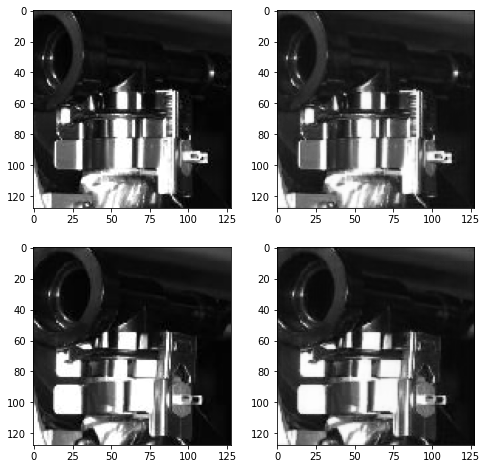

Esempio di ricostruzione su pezzi KO


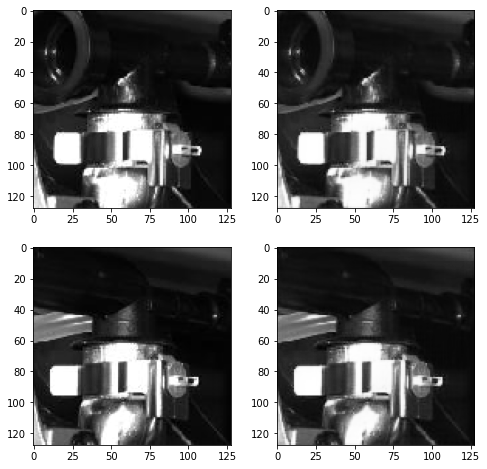

In [44]:
print("Esempio di ricostruzione su pezzi OK")
plot_rec_samples(test_generator, generator, 2)

print("Esempio di ricostruzione su pezzi KO")
plot_rec_samples(anomaly_generator, generator, 2)

La qualità di ricostruzione offerta dal generatore è di gran lunga superiore rispetto a quella ottenuta dal maodello presentato nel notebook precedente, tuttavia non si nota nessuna differenza tra le ricostruzioni dei pezzi OK e quella dei pezzi KO.

Calcoliamo gli errori di ricostruzione e verifichiamo se il generatore è in grado di riconoscere le anomalie.

In [29]:
def plot_rec_error(generator, model, n_samples = None):
    
    if n_samples == None:
      n_samples = generator.samples

    samples = 0
    score_list = []

    while samples < n_samples:
        batch = generator.next()[0]
        for i in range(len(batch)):
            img = batch[i]
            img = img.reshape((1,128,128,1))
            score = model.predict(img)
            score_list.append(score)
    
            samples += 1

    print("min score:", min(score_list))
    print("max score:", max(score_list))

    plt.scatter(x = range(len(score_list)), y = sorted(score_list))
    plt.show()
    return score_list

Errore di ricostruzione su pezzi OK
min score: 3.353090763092041
max score: 3.5277085304260254


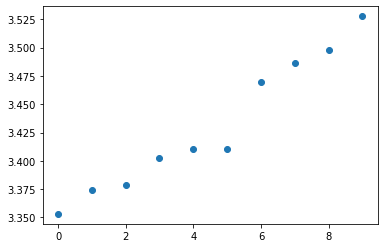

Errore di ricostruzione su pezzi KO
min score: 2.8165040016174316
max score: 3.1235790252685547


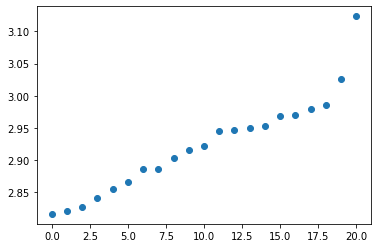

In [45]:
generator_rec_error = aae.get_generator_anomaly_score()

test_generator.reset()
print("Errore di ricostruzione su pezzi OK")
test_score = plot_rec_error(test_generator, generator_rec_error)

anomaly_generator.reset()
print("Errore di ricostruzione su pezzi KO")
anom_score = plot_rec_error(anomaly_generator, generator_rec_error)

I risultati ottenuti sono in netto contrasto con quelli prefissati, infatti l'errore di ricostruzione sulle immagini KO risulta inferiore rispetto a quello relativo alle immagini OK.

Perchè  si  possa  raggiungere  un  risultato  significativo, è necessario  coinvolgere entrambi gli Autoencoder, in modo che il risultato del generatore sia utilizzato come input del discriminatore.

L' output di quest'ultimo determina il risultato della ricostruzione.

In [46]:
adversarial = aae.get_adversarial_trained_model()

Osserviamo i risultati della ricostruzione.

Esempio di ricostruzione su pezzi OK


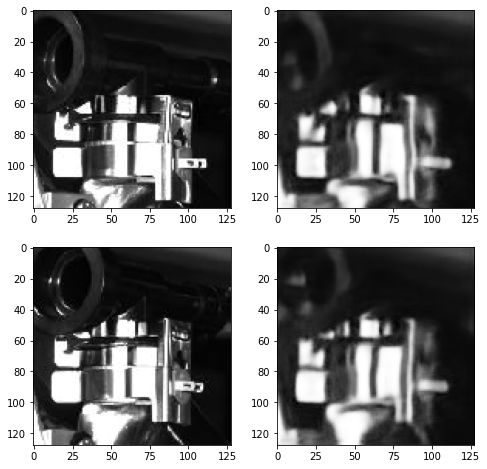

Esempio di ricostruzione su pezzi KO


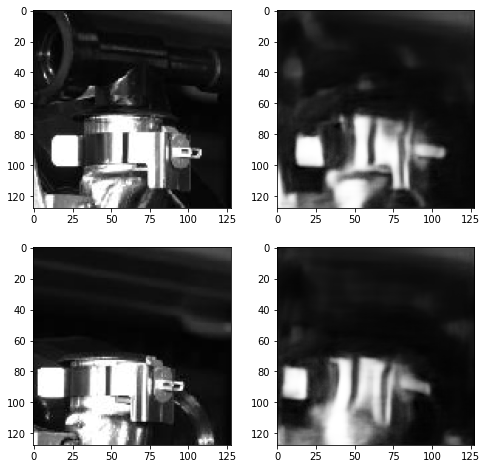

In [47]:
print("Esempio di ricostruzione su pezzi OK")
plot_rec_samples(test_generator, adversarial, 2)

print("Esempio di ricostruzione su pezzi KO")
plot_rec_samples(anomaly_generator, adversarial, 2)

In questo caso il livello di ricostruzione non è paragonabile a quella del solo generatore, nonostante ciò, ai fini dell'Anomaly Detection, l'utilizzo di entrambe le reti si dimostra molto più efficace.

Se infatti si osservano le ricostruzioni dei pezzi anolami, si nota come l'effetto di distorsione sia più accentuato nelle ricostruzione dei pezzi KO.

Calcoliamo gli errori di ricostruzione e valutiamo i risultati.

Errore di ricostruzione su pezzi OK
min score: 12.476673126220703
max score: 14.521851539611816


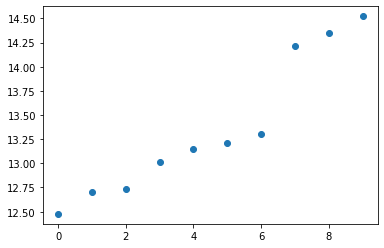

Errore di ricostruzione su pezzi KO
min score: 15.194487571716309
max score: 18.661287307739258


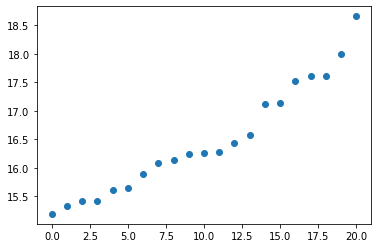

In [48]:
adversarial_rec_error = aae.get_adversarial_anomaly_score()

test_generator.reset()
print("Errore di ricostruzione su pezzi OK")
test_score = plot_rec_error(test_generator, adversarial_rec_error)

anomaly_generator.reset()
print("Errore di ricostruzione su pezzi KO")
anom_score = plot_rec_error(anomaly_generator, adversarial_rec_error)

In [49]:
threshold = 15 # Soglia di errore

true_negative = sum(i < threshold for i in test_score)
print("True Negative :", true_negative, "Over", len(test_score))
print("True Negative Rate :", true_negative * 100 / len(test_score))

false_negative = sum(i < threshold for i in anom_score)
print("False Negative :", false_negative, "Over", len(anom_score))
print("False Negative Rate :", false_negative * 100 / len(anom_score))

True Negative : 10 Over 10
True Negative Rate : 100.0
False Negative : 0 Over 21
False Negative Rate : 0.0


Il modello così addestrato in grado di distinguere perfettamente tra pezzi OK e KO.

Come prima vogliamo assicurarci di quanto la rete sia sensibile alle tolleranze di posizione delle clip metalliche, pertanto ripetiamo il calcolo dell'errore di ricostruzione, utilizzando i dataset aumentati.

In [50]:
augmented_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=5.0, 
                                                                               width_shift_range=0.05, 
                                                                               height_shift_range=0.05)
augmented_test_generator = augmented_test_datagen.flow_from_directory(
    data_path + "/test",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale")

augmented_anomaly_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=5.0, 
                                                                                  width_shift_range=0.05, 
                                                                                  height_shift_range=0.05)
augmented_anomaly_generator = augmented_anomaly_datagen.flow_from_directory(
    data_path + "/anomalies",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale" )

Found 10 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


Errore di ricostruzione su pezzi OK
min score: 9.55526065826416
max score: 13.677767753601074


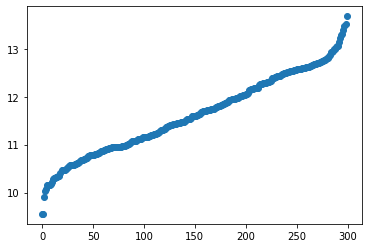

Errore di ricostruzione su pezzi KO
min score: 13.443892478942871
max score: 19.037067413330078


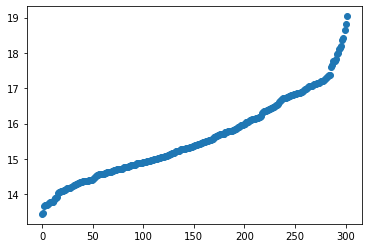

In [51]:
augmented_test_generator.reset()
print("Errore di ricostruzione su pezzi OK")
augmented_test_score = plot_rec_error(augmented_test_generator, adversarial_rec_error, 300)

augmented_anomaly_generator.reset()
print("Errore di ricostruzione su pezzi KO")
augmented_anom_score = plot_rec_error(augmented_anomaly_generator, adversarial_rec_error, 300)

Utilizzaimo un grafico ROC per determinare la soglia di errore ottimale.

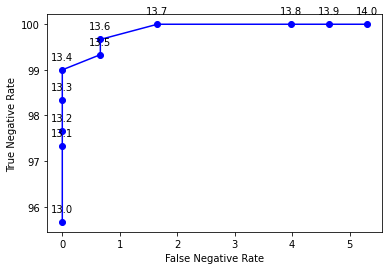

In [52]:
delta = 0.1
threshold = 14

tnr_list = []
fnr_list = []
th_list = []

while threshold > 13:

  true_negative = sum(i < threshold for i in augmented_test_score)
  false_negative = sum(i < threshold for i in augmented_anom_score)

  tn_rate = (true_negative / len(augmented_test_score)) * 100
  fn_rate = (false_negative / len(augmented_anom_score)) * 100

  tnr_list.append(tn_rate)
  fnr_list.append(fn_rate)

  th_list.append(threshold)

  threshold -= delta


plt.plot(fnr_list, tnr_list, 'bo-')
plt.xlabel("False Negative Rate")
plt.ylabel("True Negative Rate")

for i, t in enumerate(th_list) :

    x,y = fnr_list[i], tnr_list[i]
    label = "{:.1f}".format(t)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

In [53]:
threshold = 13.3

true_negative = sum(i < threshold for i in augmented_test_score)
print("True Negative :", true_negative, "Over", len(augmented_test_score))
print("True Negative Rate :", true_negative * 100 / len(augmented_test_score))

false_negative = sum(i < threshold for i in augmented_anom_score)
print("False Negative :", false_negative, "Over", len(augmented_anom_score))
print("False Negative Rate :", false_negative * 100 / len(augmented_anom_score))

True Negative : 295 Over 300
True Negative Rate : 98.33333333333333
False Negative : 0 Over 302
False Negative Rate : 0.0


Anche ruotando e traslando le immagini, il modello mantiene prestazioni superiori rispetto all'utilizzo di un singolo Autoencoder.